Precision Score: 0.5226244343891403
Predictions
1    1768
0    1759
Name: count, dtype: int64
Target
1    0.516303
0    0.483697
Name: count, dtype: float64
Precision Score with New Predictors: 0.5148095909732017


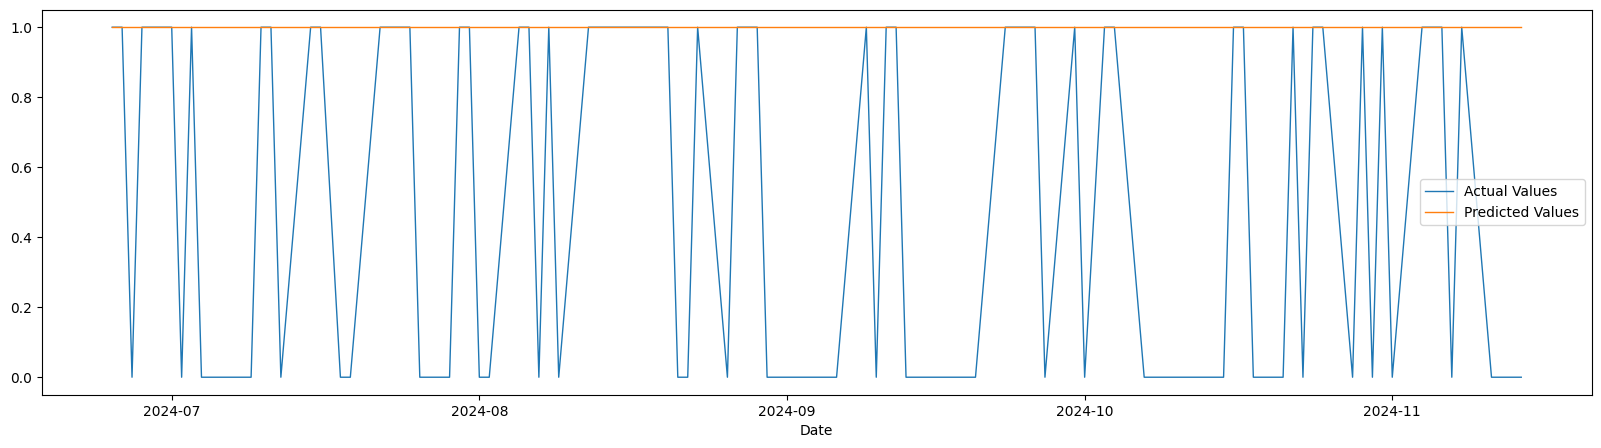

In [1]:
# Importing required libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import precision_score

# Fetch historical data for TCS
stock = yf.Ticker('TCS.NS')
data = stock.history(period="max")

# Display initial rows to understand the data structure
data = data.drop(columns=['Dividends', 'Stock Splits'])  # Drop unused columns

# Prepare the dataset for binary classification
data['Tomorrow'] = data['Close'].shift(-1)  # Target is tomorrow's Close price
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)  # 1 if price increases, else 0

# Split data into training and testing sets
train_ratio = 0.8  # 80% for training
split_index = int(len(data) * train_ratio)  # Calculate split index

train = data.iloc[:split_index].dropna()  # Drop rows with NaN values in training
test = data.iloc[split_index:].dropna()  # Drop rows with NaN values in testing

# Predictors (features)
predictors = ['High', 'Low', 'Close', 'Volume']

# Initialize SVM model with RBF kernel
svm_model = SVC(kernel='rbf', probability=True)

# Function to train and predict using the model
def predict(train, test, predictors, model):
    """
    Train the model on the training set and predict the test set.
    
    Args:
    train: Training data
    test: Testing data
    predictors: List of predictor columns
    model: SVM model
    
    Returns:
    compared_df: DataFrame with actual and predicted values
    """
    model.fit(train[predictors], train['Target'])
    
    predictions = model.predict_proba(test[predictors])[:, 1]  # Get probabilities
    predictions = (predictions >= 0.5).astype(int)  # Convert to binary predictions
    
    # Combine actual and predicted values for comparison
    compared_df = pd.concat([test['Target'], pd.Series(predictions, index=test.index, name='Predictions')], axis=1)
    return compared_df

# Function to test the model in steps
def step_test(data, model, predictors, start=2000, step=200):
    """
    Perform stepwise training and testing to simulate real-time predictions.
    
    Args:
    data: Full dataset
    model: SVM model
    predictors: List of predictor columns
    start: Starting index for stepwise training
    step: Step size for each iteration
    
    Returns:
    All_predictions: Combined predictions for all test steps
    """
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].dropna()  # Training data until current step
        test = data.iloc[i:i+step].dropna()  # Next step as testing data
        
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

# Perform stepwise testing and evaluate performance
predictions = step_test(data, svm_model, predictors)
print("Precision Score:", precision_score(predictions['Target'], predictions['Predictions']))

# Explore prediction results
print(predictions['Predictions'].value_counts())
print(predictions['Target'].value_counts() / predictions.shape[0])

# Adding new rolling predictors
days = [2, 5, 30, 100, 250, 1000]
new_predictors = []

for day in days:
    rolling_averages = data['Close'].rolling(day).mean()  # Rolling average for Close price
    
    ratio = f'Close_ratio_{day}'
    data[ratio] = data['Close'] / rolling_averages  # Close price as a ratio of rolling average
    
    trend = f'Trend_{day}'
    data[trend] = data['Target'].shift(1).rolling(day).sum()  # Rolling sum of past targets
    
    new_predictors += [ratio, trend]

# Drop NaN values caused by rolling calculations
data = data.dropna()

# Retrain and evaluate with new predictors
predictions = step_test(data, svm_model, new_predictors)
print("Precision Score with New Predictors:", precision_score(predictions['Target'], predictions['Predictions']))

# Visualizing predictions
plt.figure(figsize=(20, 5))
plt.plot(predictions['Target'][-100:], label='Actual Values', linewidth=1)
plt.plot(predictions['Predictions'][-100:], label='Predicted Values', linewidth=1)
plt.xlabel('Date')
plt.legend()
plt.show()

Precision Score: 0.5142198308993082
Precision Score with New Predictors: 0.5250176180408739


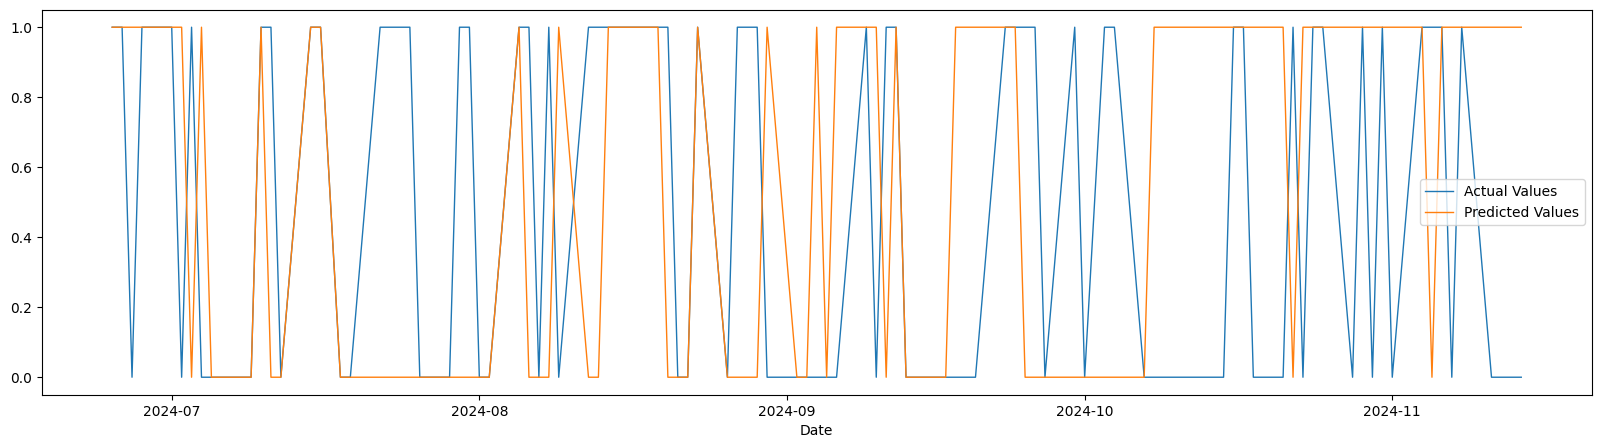

In [2]:
# Importing required libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

# Fetch historical data for TCS
stock = yf.Ticker('TCS.NS')
data = stock.history(period="max")

# Drop unused columns
data = data.drop(columns=['Dividends', 'Stock Splits'])

# Prepare the dataset for binary classification
data['Tomorrow'] = data['Close'].shift(-1)  # Target is tomorrow's Close price
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)  # 1 if price increases, else 0

# Split data into training and testing sets
train_ratio = 0.8  # 80% for training
split_index = int(len(data) * train_ratio)

train = data.iloc[:split_index].dropna()
test = data.iloc[split_index:].dropna()

# Predictors (features)
predictors = ['High', 'Low', 'Close', 'Volume']

# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Function to train and predict using the model
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    predictions = model.predict(test[predictors])
    compared_df = pd.concat([test['Target'], pd.Series(predictions, index=test.index, name='Predictions')], axis=1)
    return compared_df

# Function to test the model in steps
def step_test(data, model, predictors, start=2000, step=200):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].dropna()
        test = data.iloc[i:i+step].dropna()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

# Perform stepwise testing and evaluate performance
predictions = step_test(data, rf_model, predictors)
print("Precision Score:", precision_score(predictions['Target'], predictions['Predictions']))

# Adding new rolling predictors
days = [2, 5, 30, 100, 250, 1000]
new_predictors = []

for day in days:
    rolling_averages = data['Close'].rolling(day).mean()
    ratio = f'Close_ratio_{day}'
    data[ratio] = data['Close'] / rolling_averages
    trend = f'Trend_{day}'
    data[trend] = data['Target'].shift(1).rolling(day).sum()
    new_predictors += [ratio, trend]

# Drop NaN values caused by rolling calculations
data = data.dropna()

# Retrain and evaluate with new predictors
predictions = step_test(data, rf_model, new_predictors)
print("Precision Score with New Predictors:", precision_score(predictions['Target'], predictions['Predictions']))

# Visualizing predictions
plt.figure(figsize=(20, 5))
plt.plot(predictions['Target'][-100:], label='Actual Values', linewidth=1)
plt.plot(predictions['Predictions'][-100:], label='Predicted Values', linewidth=1)
plt.xlabel('Date')
plt.legend()
plt.show()

Precision Score: 0.5156012176560122


/home/kali/Stock-Price-Prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kali/Stock-Price-Prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Precision Score with New Predictors: 0.5222161272627537


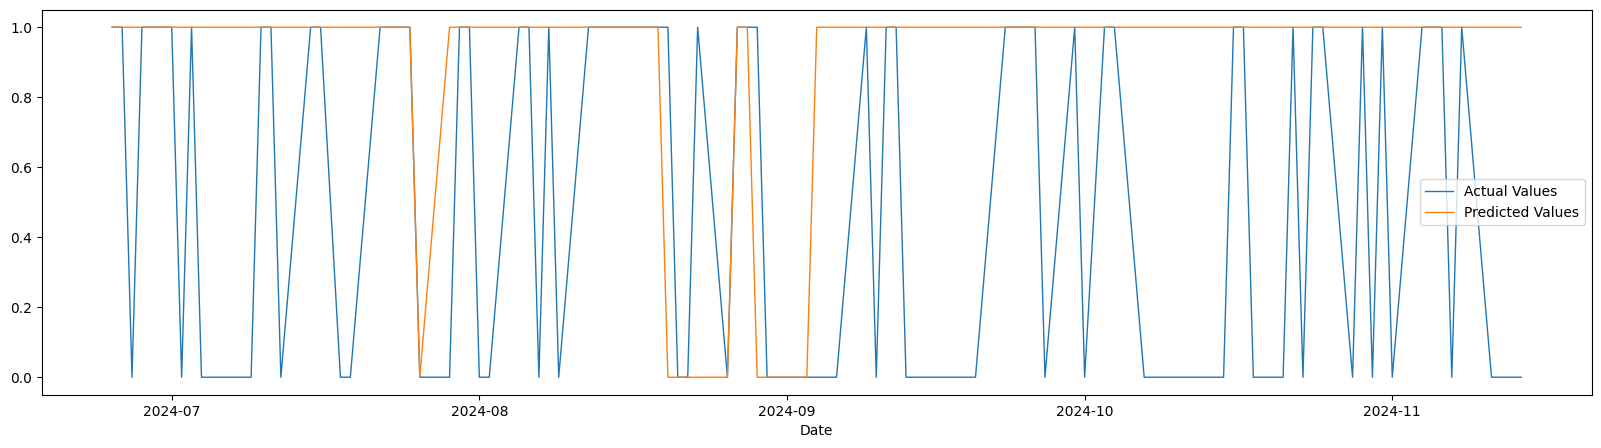

In [3]:
# Importing required libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

# Fetch historical data for TCS
stock = yf.Ticker('TCS.NS')
data = stock.history(period="max")

# Drop unused columns
data = data.drop(columns=['Dividends', 'Stock Splits'])

# Prepare the dataset for binary classification
data['Tomorrow'] = data['Close'].shift(-1)  # Target is tomorrow's Close price
data['Target'] = (data['Tomorrow'] > data['Close']).astype(int)  # 1 if price increases, else 0

# Split data into training and testing sets
train_ratio = 0.8  # 80% for training
split_index = int(len(data) * train_ratio)

train = data.iloc[:split_index].dropna()
test = data.iloc[split_index:].dropna()

# Predictors (features)
predictors = ['High', 'Low', 'Close', 'Volume']

# Initialize Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Function to train and predict using the model
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    predictions = model.predict(test[predictors])
    compared_df = pd.concat([test['Target'], pd.Series(predictions, index=test.index, name='Predictions')], axis=1)
    return compared_df

# Function to test the model in steps
def step_test(data, model, predictors, start=2000, step=200):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].dropna()
        test = data.iloc[i:i+step].dropna()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

# Perform stepwise testing and evaluate performance
predictions = step_test(data, lr_model, predictors)
print("Precision Score:", precision_score(predictions['Target'], predictions['Predictions']))

# Adding new rolling predictors
days = [2, 5, 30, 100, 250, 1000]
new_predictors = []

for day in days:
    rolling_averages = data['Close'].rolling(day).mean()
    ratio = f'Close_ratio_{day}'
    data[ratio] = data['Close'] / rolling_averages
    trend = f'Trend_{day}'
    data[trend] = data['Target'].shift(1).rolling(day).sum()
    new_predictors += [ratio, trend]

# Drop NaN values caused by rolling calculations
data = data.dropna()

# Retrain and evaluate with new predictors
predictions = step_test(data, lr_model, new_predictors)
print("Precision Score with New Predictors:", precision_score(predictions['Target'], predictions['Predictions']))

# Visualizing predictions
plt.figure(figsize=(20, 5))
plt.plot(predictions['Target'][-100:], label='Actual Values', linewidth=1)
plt.plot(predictions['Predictions'][-100:], label='Predicted Values', linewidth=1)
plt.xlabel('Date')
plt.legend()
plt.show()
